In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from keras.models import model_from_json
import cv2, os
from keras.layers import Flatten
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

In [51]:
train_dir = r"../Shashank/dataset/ImageEmotion (85-15)/train"
test_dir = r"../Shashank/dataset/ImageEmotion (85-15)/test"

SEED = 12
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
momentum = 0.9
EPOCHS = 500
#FINE_TUNING_EPOCHS = 30
LR = 0.001
NUM_CLASSES = 8
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Amusement', 'Anger', 'Awe', 'Contentment', 'Disgust', 'Excitement', 'Fear', 'Sadness']
CLASS_LABELS_EMOJIS = ["🥳", "😡", "😯", "😌", "🤢" ,"🤩", "😱" , "😔" ]

In [52]:
#preprocess_fun = tf.keras.applications.resnet.preprocess_input

train_datagen = ImageDataGenerator(#horizontal_flip=True,
                                   #width_shift_range=0.1,
                                   #height_shift_range=0.05,
                                    #rescale = 1./255,
                                   validation_split = 0,
                                   #preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(
                                    #rescale = 1./255,
                                  validation_split = 0,
                                  #preprocessing_function=preprocess_fun
                                 )

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 18559 images belonging to 8 classes.
Found 0 images belonging to 8 classes.
Found 3277 images belonging to 8 classes.


In [6]:
#for Idea2
emotion_model1 = tf.keras.applications.densenet.DenseNet201(input_shape=(224,224,3), include_top= False,
                                                                 weights= 'imagenet')
emotion_model2 = tf.keras.applications.resnet.ResNet101(input_shape=(224,224,3), include_top= False,
                                                                 weights= 'imagenet')

preprocess_fn1 = tf.keras.applications.densenet.preprocess_input 
preprocess_fn2 = tf.keras.applications.resnet.preprocess_input 

def emotion_model1_feature_extractor(inputs):
    y = emotion_model1(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

def emotion_model2_feature_extractor(inputs):
    y = emotion_model2(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

# def mainobject_model_feature_extractor(inputs):
#     y = mainobject_model(inputs)
#     y = tf.keras.layers.GlobalAveragePooling2D()(y)
#     x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
#     return x, y

def classifier(features):
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', 
                              name='classification')(features)
    
    return x
        
def final_model(inputs, emotion_model1, emotion_model2, mainobject_model):
    x, emotion_features1 = emotion_model1(preprocess_fn1(inputs)*1./255)
    x, emotion_features2 = emotion_model2(preprocess_fn2(inputs)*1./255)
    mainobject_features = mainobject_model(preprocess_fn2(inputs)*1./255)
    
    merged_features = tf.concat([mainobject_features, 0.75*emotion_features1, 0.25*emotion_features2], axis=1)
    classification_output = classifier(merged_features)
    
    return classification_output, merged_features

def define_compile_model(emotionweights1_path, emotionweights2_path):
    
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    
    emotion_model1 = tf.keras.Model(inputs= inputs, outputs= emotion_model1_feature_extractor(inputs))
    emotion_model1.load_weights(emotionweights1_path)
    emotion_model2 = tf.keras.Model(inputs= inputs, outputs= emotion_model2_feature_extractor(inputs))
    emotion_model2.load_weights(emotionweights2_path)
    mainobject_model = tf.keras.applications.resnet.ResNet101(input_shape=(224,224,3), include_top= True, 
                                                                 weights='imagenet')
    mainobject_model.trainable = False
    
    classification_output, features = final_model(inputs, emotion_model1, emotion_model2, mainobject_model) 
    model = tf.keras.Model(inputs= inputs, outputs= [classification_output, features])
    model.compile(optimizer=tf.keras.optimizers.SGD(0.001), 
                loss='categorical_crossentropy',
                metrics = ['acc'])
  
    return model

In [5]:
#for Idea1
emotion_model = tf.keras.applications.densenet.DenseNet201(input_shape=(224,224,3), include_top= False,
                                                                 weights= 'imagenet')

def emotion_model_feature_extractor(inputs):
    y = emotion_model(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

# def mainobject_model_feature_extractor(inputs):
#     y = mainobject_model(inputs)
#     y = tf.keras.layers.GlobalAveragePooling2D()(y)
#     x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
#     return x, y

def classifier(features):
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', 
                              name='classification')(features)
    
    return x
        
def final_model(inputs, emotion_model, mainobject_model):
    preprocess_fn1 = tf.keras.applications.densenet.preprocess_input 
    preprocess_fn2 = tf.keras.applications.resnet.preprocess_input 
    x, emotion_features = emotion_model(preprocess_fn1(inputs)*1./255)
    mainobject_features = mainobject_model(preprocess_fn2(inputs)*1./255)
    
    merged_features = tf.concat([mainobject_features, emotion_features], axis=1)
    classification_output = classifier(merged_features)
    
    return classification_output, merged_features

def define_compile_model(emotionweights_path):
    
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    
    emotion_model = tf.keras.Model(inputs= inputs, outputs= emotion_model_feature_extractor(inputs))
    emotion_model.load_weights(emotionweights_path)
    mainobject_model = tf.keras.applications.resnet.ResNet101(input_shape=(224,224,3), include_top= True, 
                                                                 weights='imagenet')
    mainobject_model.trainable = False
    
    classification_output, merged_features = final_model(inputs, emotion_model, mainobject_model) 
    model = tf.keras.Model(inputs= inputs, outputs= [classification_output, merged_features])
    model.compile(optimizer=tf.keras.optimizers.SGD(0.001), 
                loss='categorical_crossentropy',
                metrics = ['acc'])
  
    return model

2022-10-08 15:36:51.696960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 15:36:51.697089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 15:36:51.721192: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/stud1/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-10-08 15:36:51.721203: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://w

In [48]:
#Idea4_beta=0
emotion_model1 = tf.keras.applications.densenet.DenseNet201(input_shape=(224,224,3), include_top= False,
                                                                 weights= 'imagenet')
emotion_model2 = tf.keras.applications.resnet.ResNet101(input_shape=(224,224,3), include_top= False,
                                                                 weights= 'imagenet')

preprocess_fn1 = tf.keras.applications.densenet.preprocess_input 
preprocess_fn2 = tf.keras.applications.resnet.preprocess_input 

def emotion_model1_feature_extractor(inputs):
    y = emotion_model1(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

def emotion_model2_feature_extractor(inputs):
    y = emotion_model2(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

# def mainobject_model_feature_extractor(inputs):
#     y = mainobject_model(inputs)
#     y = tf.keras.layers.GlobalAveragePooling2D()(y)
#     x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
#     return x, y

def classifier(features):
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', 
                              name='classification')(features)
    
    return x
        
def final_model(inputs, emotion_model1, emotion_model2):
    x, emotion_features1 = emotion_model1(preprocess_fn1(inputs)*1./255)
    x, emotion_features2 = emotion_model2(preprocess_fn2(inputs)*1./255)
    
    merged_emotion_features = tf.concat([emotion_features1, emotion_features2], axis=1)
    classification_output = classifier(merged_emotion_features)
    
    return classification_output, merged_emotion_features

def define_compile_model(emotionweights1_path, emotionweights2_path):
    
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    
    emotion_model1 = tf.keras.Model(inputs= inputs, outputs= emotion_model1_feature_extractor(inputs))
    emotion_model1.load_weights(emotionweights1_path)
    emotion_model2 = tf.keras.Model(inputs= inputs, outputs= emotion_model2_feature_extractor(inputs))
    emotion_model2.load_weights(emotionweights2_path)
    
    classification_output,merged_emotion_features = final_model(inputs, emotion_model1, emotion_model2) 
    model = tf.keras.Model(inputs= inputs, outputs= [classification_output, merged_emotion_features])
    model.compile(optimizer=tf.keras.optimizers.SGD(0.001), 
                loss='categorical_crossentropy',
                metrics = ['acc'])
  
    return model

In [38]:
#Idea4_beta=0.25,0.5,0.75
emotion_model1 = tf.keras.applications.densenet.DenseNet201(input_shape=(224,224,3), include_top= False,
                                                                 weights= 'imagenet')
emotion_model2 = tf.keras.applications.resnet.ResNet101(input_shape=(224,224,3), include_top= False,
                                                                 weights= 'imagenet')

preprocess_fn1 = tf.keras.applications.densenet.preprocess_input 
preprocess_fn2 = tf.keras.applications.resnet.preprocess_input 

def emotion_model1_feature_extractor(inputs):
    y = emotion_model1(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

def emotion_model2_feature_extractor(inputs):
    y = emotion_model2(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

# def mainobject_model_feature_extractor(inputs):
#     y = mainobject_model(inputs)
#     y = tf.keras.layers.GlobalAveragePooling2D()(y)
#     x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
#     return x, y

def classifier(features):
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', 
                              name='classification')(features)
    
    return x
        
def final_model(inputs, emotion_model1, emotion_model2, mainobject_model):
    x, emotion_features1 = emotion_model1(preprocess_fn1(inputs)*1./255)
    x, emotion_features2 = emotion_model2(preprocess_fn2(inputs)*1./255)
    mainobject_features = mainobject_model(preprocess_fn2(inputs)*1./255)
    
    merged_emotion_features = tf.concat([emotion_features1, emotion_features2], axis=1)
    merged_features = tf.concat([0.75*mainobject_features, 0.2Ours_OnlyTest_withoutFunny5*merged_emotion_features], axis=1)
    classification_output = classifier(merged_features)
    
    return classification_output, merged_features

def define_compile_model(emotionweights1_path, emotionweights2_path):
    
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    
    emotion_model1 = tf.keras.Model(inputs= inputs, outputs= emotion_model1_feature_extractor(inputs))
    emotion_model1.load_weights(emotionweights1_path)
    emotion_model2 = tf.keras.Model(inputs= inputs, outputs= emotion_model2_feature_extractor(inputs))
    emotion_model2.load_weights(emotionweights2_path)
    mainobject_model = tf.keras.applications.resnet.ResNet101(input_shape=(224,224,3), include_top= True, 
                                                                 weights='imagenet')
    mainobject_model.trainable = False
    
    classification_output, merged_features = final_model(inputs, emotion_model1, emotion_model2, mainobject_model) 
    model = tf.keras.Model(inputs= inputs, outputs= [classification_output, merged_features])
    model.compile(optimizer=tf.keras.optimizers.SGD(0.001), 
                loss='categorical_crossentropy',
                metrics = ['acc'])
  
    return model

In [49]:
#for Idea4_beta=0
emotionweights1_path = r'../Shashank/h5 files/DenseNet201-010-0.780538-0.641440.h5'
emotionweights2_path = r'../Shashank/h5 files/ResNet101-009-0.762864-0.650595.h5'
model = define_compile_model(emotionweights1_path, emotionweights2_path)
model.load_weights(r'h5 files/Idea4_DenseNet201+ResNet101_100-008-0.781723-0.667074.h5')

model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_24 (TFOpLambda  (None, 224, 224, 3)  0          ['input_22[0][0]']               
 )                                                                                                
                                                                                                  
 tf.nn.bias_add_14 (TFOpLambda)  (None, 224, 224, 3)  0          ['tf.math.truediv_24[0][0]']     
                                                                                           

In [39]:
#for Idea4_beta=0.25,0.5,0.75
emotionweights1_path = r'../Shashank/h5 files/DenseNet201-010-0.780538-0.641440.h5'
emotionweights2_path = r'../Shashank/h5 files/ResNet101-009-0.762864-0.650595.h5'
model = define_compile_model(emotionweights1_path, emotionweights2_path)
model.load_weights(r'Idea4_DenseNet201+ResNet101_25-003-0.731882-0.657614.h5')

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_19 (TFOpLambda  (None, 224, 224, 3)  0          ['input_18[0][0]']               
 )                                                                                                
                                                                                                  
 tf.nn.bias_add_11 (TFOpLambda)  (None, 224, 224, 3)  0          ['tf.math.truediv_19[0][0]']     
                                                                                           

In [8]:
#for Idea2
emotionweights1_path = r'../Shashank/h5 files/DenseNet201-010-0.780538-0.641440.h5'
emotionweights2_path = r'../Shashank/h5 files/ResNet101-009-0.762864-0.650595.h5'
model = define_compile_model(emotionweights1_path, emotionweights2_path)
model.load_weights(r'../Shashank/h5 files/Idea2_DenseNet201+ResNet101-002-0.783663-0.657614_75-25.h5')

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_5 (TFOpLambda)  (None, 224, 224, 3)  0          ['input_7[0][0]']                
                                                                                                  
 tf.nn.bias_add_3 (TFOpLambda)  (None, 224, 224, 3)  0           ['tf.math.truediv_5[0][0]']      
                                                                                                  
 tf.__operators__.getitem_2 (Sl  (None, 224, 224, 3)  0          ['input_7[0][0]']          

In [7]:
#for Idea1
emotionweights_path = r'../Shashank/h5 files/DenseNet201-010-0.780538-0.641440.h5'
model = define_compile_model(emotionweights_path)
model.load_weights(r'h5 files/Idea1.1_DenseNet201-010-0.811197-0.648459.h5')

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_4 (TFOpLambda)  (None, 224, 224, 3)  0          ['input_4[0][0]']                
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 224, 224, 3)  0          ['input_4[0][0]']                
 icingOpLambda)                                                                                   
                                                                                            

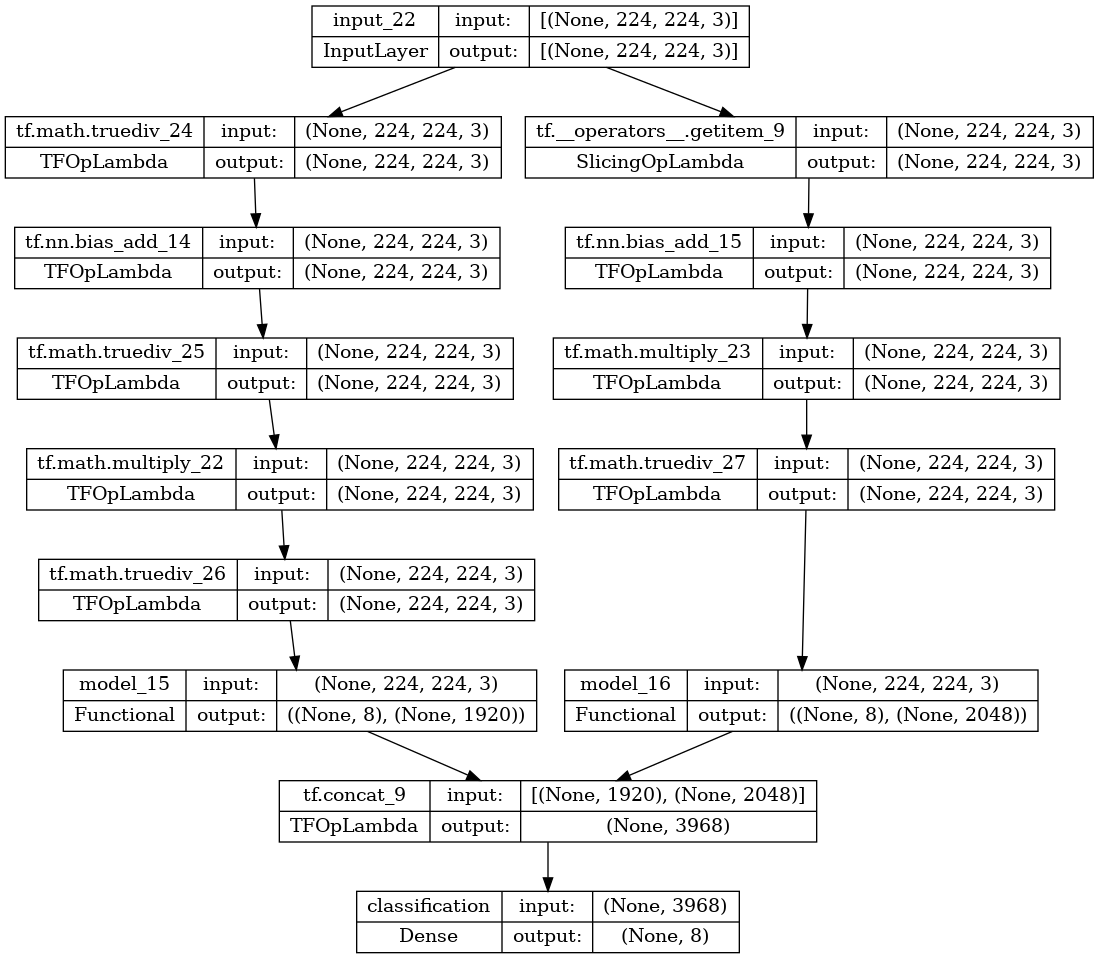

In [50]:
#for plotting model
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)


from keras.utils.vis_utils import plot_model    
plot_model(model, to_file='model_i1.png', show_shapes=True, show_layer_names=True)

In [13]:
#saving the  model to be used later
fer_json = model.to_json()
with open("MobileNet_base.json", "w") as json_file:
    json_file.write(fer_json)
#model.save_weights("VGG16_512.h5") #make sure to rename this file after each 100 epochs
print("Saved model somewhere")

Saved model somewhere


In [12]:
x, CNN_features = model(train_generator)

TypeError: Inputs to a layer should be tensors. Got: <keras.preprocessing.image.DirectoryIterator object at 0x7f752ddc6520>

In [17]:
CNN_features.shape

TensorShape([128, 7, 7, 1024])

In [17]:
test_generator[0][0].shape

(64, 224, 224, 3)

In [45]:
#feature extraction for small scale datasets
def feature_extractor(sample_count, generator):
    data = np.zeros(shape=(sample_count, 4968))
    batch_no = 0
    
    while batch_no < (sample_count // BATCH_SIZE) + 1:
        data[batch_no * BATCH_SIZE: (batch_no+1) * BATCH_SIZE] = model(generator[batch_no][0])[-1]
        batch_no += 1
        print(f'Done for batch {batch_no}')
        
    return data

train_data = feature_extractor(280, train_generator)
print('Done for train.')
test_data = feature_extractor(806, test_generator)
print('Done for test')

Done for batch 1
Done for batch 2
Done for batch 3
Done for batch 4
Done for batch 5
Done for train.
Done for batch 1
Done for batch 2
Done for batch 3
Done for batch 4
Done for batch 5
Done for batch 6
Done for batch 7
Done for batch 8
Done for batch 9
Done for batch 10
Done for batch 11
Done for batch 12
Done for batch 13
Done for test


In [46]:
test_data.shape

(806, 4968)

In [47]:
np.save('AbstractPaintings_Idea4_beta=0.75_featuresdata.npy', train_data)
np.save('Artphoto_Idea4_beta=0.75_featuresdata.npy', test_data)

In [53]:
#feature extraction on Image Emotion dataset
def feature_extractor(sample_count, generator):
    data = np.zeros(shape=(sample_count, 3968))
    batch_no = 0
    
    while batch_no < (sample_count // BATCH_SIZE) + 1:
        data[batch_no * BATCH_SIZE: (batch_no+1) * BATCH_SIZE] = model(generator[batch_no][0])[-1]
        batch_no += 1
        print(f'Done for batch {batch_no}')
        
    return data

train_data = feature_extractor(18559, train_generator)
print('Done for train.')
test_data = feature_extractor(3277, test_generator)
print('Done for test')

Done for batch 1
Done for batch 2
Done for batch 3
Done for batch 4
Done for batch 5
Done for batch 6
Done for batch 7
Done for batch 8
Done for batch 9
Done for batch 10
Done for batch 11
Done for batch 12
Done for batch 13
Done for batch 14
Done for batch 15
Done for batch 16
Done for batch 17
Done for batch 18
Done for batch 19
Done for batch 20
Done for batch 21
Done for batch 22
Done for batch 23
Done for batch 24
Done for batch 25
Done for batch 26
Done for batch 27
Done for batch 28
Done for batch 29
Done for batch 30
Done for batch 31
Done for batch 32
Done for batch 33
Done for batch 34
Done for batch 35
Done for batch 36
Done for batch 37
Done for batch 38
Done for batch 39
Done for batch 40
Done for batch 41
Done for batch 42
Done for batch 43
Done for batch 44
Done for batch 45
Done for batch 46
Done for batch 47
Done for batch 48
Done for batch 49
Done for batch 50
Done for batch 51
Done for batch 52
Done for batch 53
Done for batch 54
Done for batch 55
Done for batch 56
D

In [54]:
np.save('FeatureFiles/ImageEmotion_train_Idea4_beta=0_featuresdata.npy', train_data)
np.save('FeatureFiles/ImageEmotion_test_Idea4_beta=0_featuresdata.npy', test_data)

In [13]:
test_data[1]

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.06014271, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [1.09325528, 0.36581939, 0.        , ..., 0.        ,
         0.        , 4.48725748],
        ...,
        [6.        , 0.        , 0.        , ..., 6.        ,
         0.        , 0.70909601],
        [6. 

In [58]:
""" Returns mean value of RGB """
def mean(inputs):
    # flatten image to be 2D and compute mean rgb
    mean_rgb_val = mean_helper(inputs)
    # convert image to hsv scale
    #hsv = cv2.cvtColor(img_data, cv2.COLOR_RGB2HSV)
    hsv = tf.image.rgb_to_hsv(inputs)
    # calculate mean
    mean_hsv_val = mean_helper(hsv)
    return mean_rgb_val, mean_hsv_val

""" Calculates mean value of a plane given a 3D matrix """
def mean_helper(org_mat):
    # "flatten" matrix to a 2D matrix
    temp = org_mat
    temp = tf.math.reduce_mean(temp,axis=1)
    temp = tf.math.reduce_mean(temp,axis=1)
    mean_val = temp
    return mean_val

""" Calculates pleasure, arousal, dominance values of the image"""
def calculate_pad(hsv):
    batch=hsv.shape[0]
    i = 0
    while i < batch:
    #for i in range(BATCH_SIZE):
        saturation = hsv[i][1]
        brightness = hsv[i][2] # or 'value' in hsv
        pleasure = 0.69 * brightness + 0.22 * saturation
        arousal = 0.31 * brightness + 0.6 * saturation
        dominance = 0.76 * brightness + 0.32 * saturation
        pleasure = tf.reshape(pleasure, (1,1))
        arousal = tf.reshape(arousal, (1,1))
        dominance = tf.reshape(dominance, (1,1))
        pad_per_image = tf.concat([pleasure, arousal, dominance],axis= 1)
        pad_per_image = tf.reshape(pad_per_image, (1,1,3))
        if i == 0:
            pad = pad_per_image
        else:
            pad = tf.concat([pad, pad_per_image], axis= 0)
        i += 1
    return pad

def feature_extractor(inputs):
    rgb, hsv = mean(inputs)
    rgb = Flatten()(rgb)
    pad = Flatten()(calculate_pad(hsv))
    hsv = Flatten()(hsv)
    low_level_features = tf.concat([rgb, pad, hsv], axis= 1)
    return low_level_features

In [59]:
def lowfeature_extractor(sample_count, data):
    BATCH_SIZE = 128
    lowfeatures = np.zeros(shape=(sample_count, 9))
    batch_no = 0
    while batch_no < (sample_count // BATCH_SIZE) + 1:
        lowfeatures[batch_no * BATCH_SIZE: (batch_no+1) * BATCH_SIZE] = feature_extractor(data[batch_no * BATCH_SIZE: (batch_no+1) * BATCH_SIZE])
        print(f'Done for batch {batch_no}')
        batch_no += 1
        
    return lowfeatures

train_lowfeatures = lowfeature_extractor(18559, train_data)
test_lowfeatures = lowfeature_extractor(3277, test_data)

Done for batch 0
Done for batch 1
Done for batch 2
Done for batch 3
Done for batch 4
Done for batch 5
Done for batch 6
Done for batch 7
Done for batch 8
Done for batch 9
Done for batch 10
Done for batch 11
Done for batch 12
Done for batch 13
Done for batch 14
Done for batch 15
Done for batch 16
Done for batch 17
Done for batch 18
Done for batch 19
Done for batch 20
Done for batch 21
Done for batch 22
Done for batch 23
Done for batch 24
Done for batch 25
Done for batch 26
Done for batch 27
Done for batch 28
Done for batch 29
Done for batch 30
Done for batch 31
Done for batch 32
Done for batch 33
Done for batch 34
Done for batch 35
Done for batch 36
Done for batch 37
Done for batch 38
Done for batch 39
Done for batch 40
Done for batch 41
Done for batch 42
Done for batch 43
Done for batch 44
Done for batch 45
Done for batch 46
Done for batch 47
Done for batch 48
Done for batch 49
Done for batch 50
Done for batch 51
Done for batch 52
Done for batch 53
Done for batch 54
Done for batch 55
Do

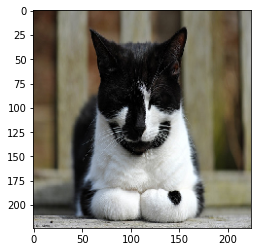

In [60]:
plt.imshow(train_data[2])

In [66]:
train_lowfeatures[2]

array([0.43332976, 0.4179579 , 0.37276828, 0.34829712, 0.2566067 ,
       0.39915136, 0.23102526, 0.19978748, 0.4410781 ])

In [62]:
np.save('train_lowfeatures.npy', train_lowfeatures)
np.save('test_lowfeatures.npy', test_lowfeatures)

In [11]:
def classifier(inputs):
    y = tf.keras.applications.mobilenet.MobileNet(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights= 'imagenet',
                                                       include_top=False)(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(8, activation='softmax', name='classification', kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    
    return x,y
    
        
def final_model(inputs):
    classification_output = classifier(inputs)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs= inputs, outputs= classification_output)
    model.load_weights(r"h5 files/MobileNet_fulltrain_017-0.825637-0.616723.h5")
    model.compile(optimizer=tf.keras.optimizers.SGD(0.01), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
    
  
    return model

In [12]:
model = define_compile_model()

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 classification (Dense)      (None, 8)                 8200      
                                                                 
Total params: 3,237,064
Trainable params: 3,215,176
Non-trainable params: 21,888
_________________________________________________________________


In [13]:
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 1024))  
    labels = np.zeros(shape=(sample_count, NUM_CLASSES))
    
    i=0
    for inputs_batch, labels_batch in generator:
        x, features_batch = model(inputs_batch)
        features[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_generator,18559)
print("train done")  
test_features, test_labels = extract_features(test_generator, 3277)
print("test done")

train done
test done


In [9]:
#saving features

np.save(r'FeatureFiles/MobileNet_IER_trainfeatures_(7,7,1024).npy', train_features)
np.save(r'FeatureFiles/MobileNet_IER_trainlabels.npy', train_labels)
np.save(r'FeatureFiles/MobileNet_IER_testfeatures_(7,7,1024).npy', test_features)
np.save(r'FeatureFiles/MobileNet_IER_testlabels.npy', test_labels)